# Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==25].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
24,25,5,2015-07-31,14180,1586,1,1,0,1,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN
1139,25,4,2015-07-30,11272,1422,1,1,0,1,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN
2254,25,3,2015-07-29,10527,1254,1,1,0,1,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN
3369,25,2,2015-07-28,10865,1363,1,1,0,1,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN
4484,25,1,2015-07-27,11806,1536,1,1,0,1,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN


In [9]:
#Store_25
df_new_store25=df_new[df_new['store']==25]

In [10]:
# transform datatype of the variable data to datetime
df_new_store25['date'] = pd.to_datetime( df_new_store25['date'])

In [11]:
df_new_store25.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 24 to 1016119
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       

In [13]:
# Check NAN values
missing_count = df_new_store25.isnull().sum() # the count of missing values
value_count = df_new_store25.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


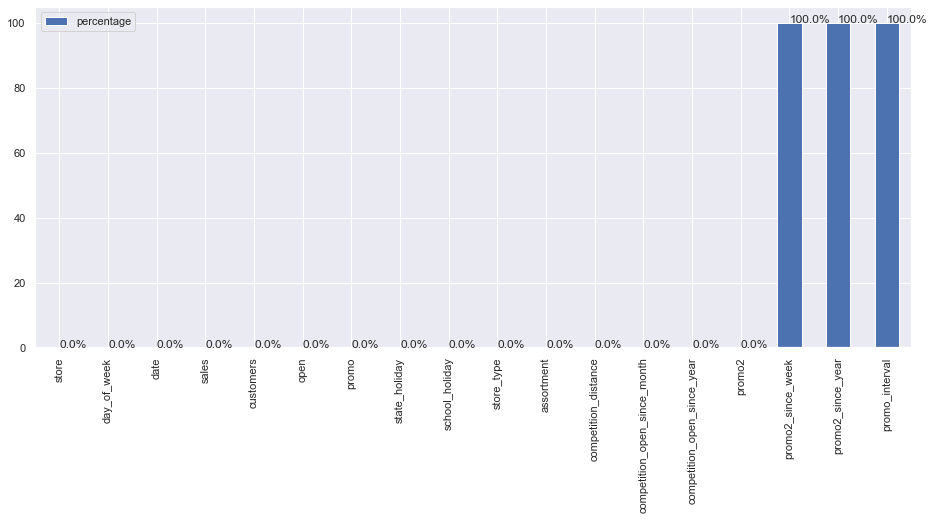

In [14]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [16]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store25=df_new_store25.drop(['promo2_since_week', 'promo2_since_year','promo_interval'], axis = 1)

In [17]:
df_new_store25.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

In [18]:
df_new_store25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 24 to 1016119
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       

In [19]:
df_new_store25 = df_new_store25.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64',})
df_new_store25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 24 to 1016119
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       

In [20]:
# Let's copy the dataset
df_store25 = df_new_store25.copy()

In [21]:
df_store25.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
24,25,5,2015-07-31,14180,1586,1,1,0,1,c,a,430.0,4,2003,0
1139,25,4,2015-07-30,11272,1422,1,1,0,1,c,a,430.0,4,2003,0
2254,25,3,2015-07-29,10527,1254,1,1,0,1,c,a,430.0,4,2003,0
3369,25,2,2015-07-28,10865,1363,1,1,0,1,c,a,430.0,4,2003,0
4484,25,1,2015-07-27,11806,1536,1,1,0,1,c,a,430.0,4,2003,0


**Descriptive Statistics**

In [22]:
df_store25.describe().T

,count,mean,std,min,25%,50%,75%,max
store,942.0,25.000000,0.000000,25.0,25.00,25.0,25.00,25.0
day_of_week,942.0,3.997877,1.998404,1.0,2.00,4.0,6.00,7.0
sales,942.0,8892.311040,5151.671996,0.0,7858.75,9806.0,12125.25,24882.0
customers,942.0,1250.288747,686.376385,0.0,1182.00,1456.5,1692.00,2835.0
open,942.0,0.798301,0.401481,0.0,1.00,1.0,1.00,1.0
promo,942.0,0.382166,0.486175,0.0,0.00,0.0,1.00,1.0
school_holiday,942.0,0.180467,0.384780,0.0,0.00,0.0,0.00,1.0
competition_distance,942.0,430.000000,0.000000,430.0,430.00,430.0,430.00,430.0
competition_open_since_month,942.0,4.000000,0.000000,4.0,4.00,4.0,4.00,4.0
competition_open_since_year,942.0,2003.000000,0.000000,2003.0,2003.00,2003.0,2003.00,2003.0


In [24]:
# separate numerical and categorical attributes
num_attributes = df_store25.select_dtypes( include = 'number')
cate_attributes = df_store25.select_dtypes( include = 'object')

**Numerical Attributes**

In [26]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,25.0,25.0,0.0,25.000000,25.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,24882.0,24882.0,8892.311040,9806.0,5148.936837,-0.552010,-0.301213
3,customers,0.0,2835.0,2835.0,1250.288747,1456.5,686.011969,-0.932582,-0.372510
4,open,0.0,1.0,1.0,0.798301,1.0,0.401268,-1.489166,0.218073
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.180467,0.0,0.384576,1.664393,0.771837
7,competition_distance,430.0,430.0,0.0,430.000000,430.0,0.000000,0.000000,0.000000
8,competition_open_since_month,4.0,4.0,0.0,4.000000,4.0,0.000000,0.000000,0.000000
9,competition_open_since_year,2003.0,2003.0,0.0,2003.000000,2003.0,0.000000,0.000000,0.000000


**Categorical Attributes**


In [27]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday    5
store_type       1
assortment       1
dtype: int64

In [29]:
#Let's check the unique values
print(df_store25['state_holiday'].unique())
print(df_store25['store_type'].unique())
print(df_store25['assortment'].unique())

['0' 'a' 'b' 'c' 0]
['c']
['a']


# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

Response Variable (target)

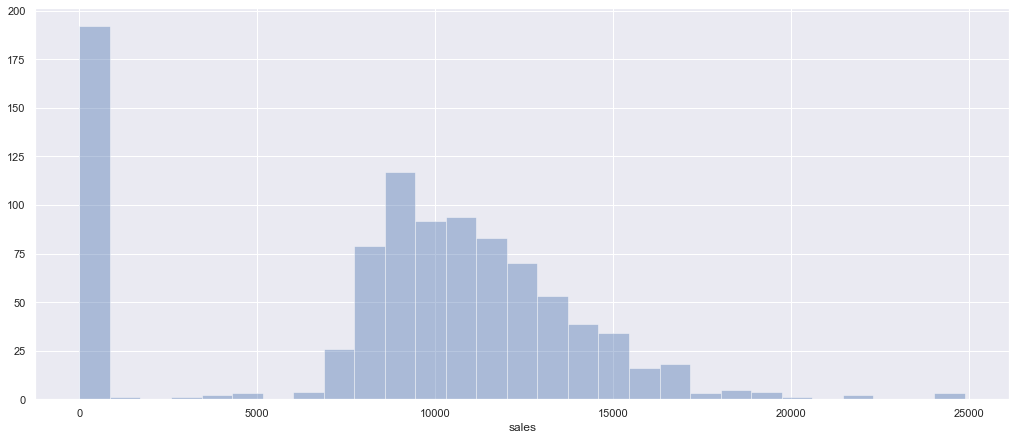

In [31]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store25['sales'], kde = False);
plt.show()

 **Numerical Variable**

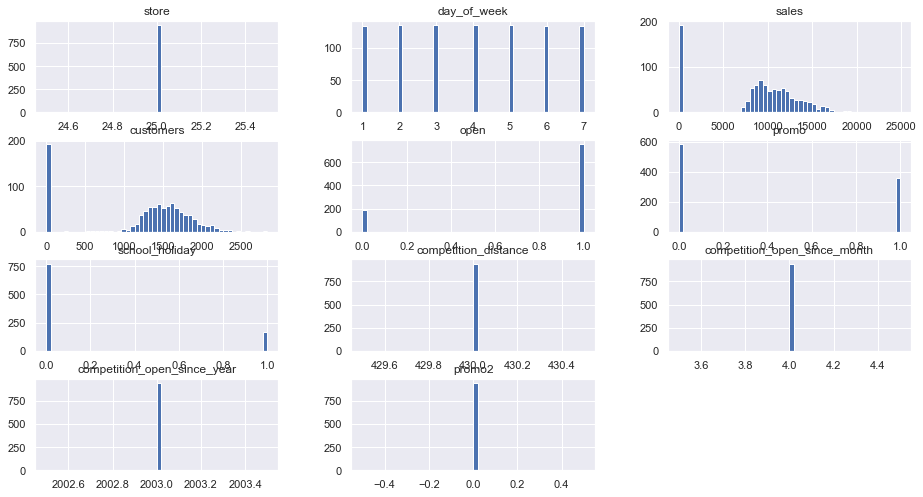

In [32]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [33]:
df_store25['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [34]:
df_store25['open'].value_counts()
# value count of store is open or not

1    752
0    190
Name: open, dtype: int64

In [35]:
df_store25['promo'].value_counts()
# value count of promo

0    582
1    360
Name: promo, dtype: int64

In [36]:
df_store25['state_holiday'].value_counts()
# value count of state_holida

0    784
0    129
a     19
b      6
c      4
Name: state_holiday, dtype: int64

In [37]:
df_store25['store_type'].value_counts()
# value count of state_holiday

c    942
Name: store_type, dtype: int64

In [38]:
df_store25['assortment'].value_counts()
# value count of state_holiday

a    942
Name: assortment, dtype: int64

In [40]:
df_store25['competition_distance'].value_counts()
# value count of competition_distance

430.0    942
Name: competition_distance, dtype: int64

In [41]:
df_store25['competition_open_since_month'].value_counts()
# value count of competition_open_since_month

4    942
Name: competition_open_since_month, dtype: int64

In [42]:
df_store25['competition_open_since_year'].value_counts()
# value count of competition_open_since_month

2003    942
Name: competition_open_since_year, dtype: int64

In [43]:
df_store25['promo2'].value_counts()
# value count of competition_open_since_month

0    942
Name: promo2, dtype: int64

**Categorical Variable**

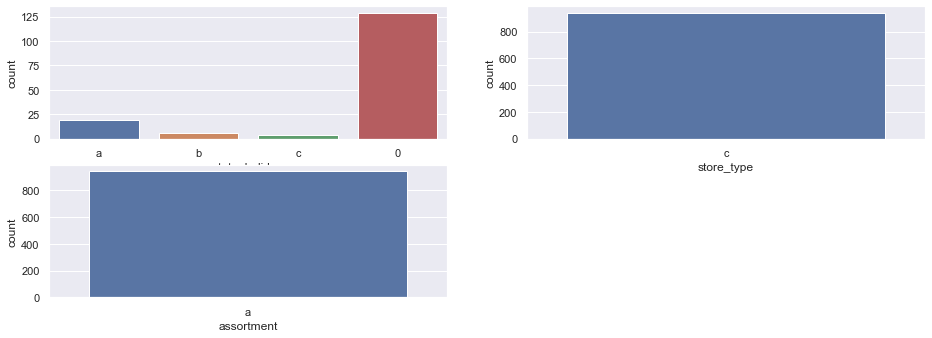

In [45]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store25[df_store25['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store25, x = df_store25['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store25, x = df_store25['assortment'])

plt.show()

In [46]:
df_store25[df_store25['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
5599,25,7,2015-07-26,0,0,0,0,0,0,c,a,430.0,4,2003,0
13404,25,7,2015-07-19,0,0,0,0,0,0,c,a,430.0,4,2003,0
21209,25,7,2015-07-12,0,0,0,0,0,0,c,a,430.0,4,2003,0
29014,25,7,2015-07-05,0,0,0,0,0,0,c,a,430.0,4,2003,0
36819,25,7,2015-06-28,0,0,0,0,0,0,c,a,430.0,4,2003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987129,25,7,2013-01-27,0,0,0,0,0,0,c,a,430.0,4,2003,0
994934,25,7,2013-01-20,0,0,0,0,0,0,c,a,430.0,4,2003,0
1002739,25,7,2013-01-13,0,0,0,0,0,0,c,a,430.0,4,2003,0
1010544,25,7,2013-01-06,0,0,0,0,0,0,c,a,430.0,4,2003,0


In [47]:
df_store25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 24 to 1016119
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'c'

-    All the rows of column-assortment belongs to 'a'

-    All the rows of columns-competition_distance to 430

-    All the competition is opened since month-4

-    All the competition is opened since 2003

-    All the rows of promo2 belogs to 0

**Bivariate Analysis**





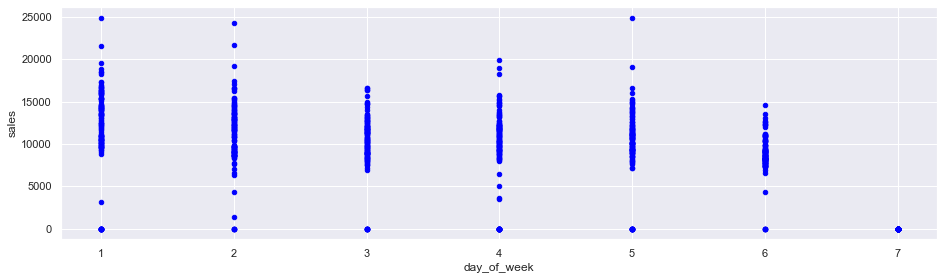

In [48]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store25[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

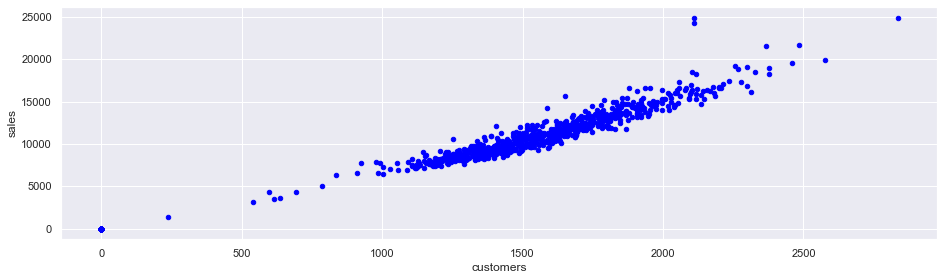

In [49]:
#Let's draw a scatter plot between Sales and Customers
df_store25[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

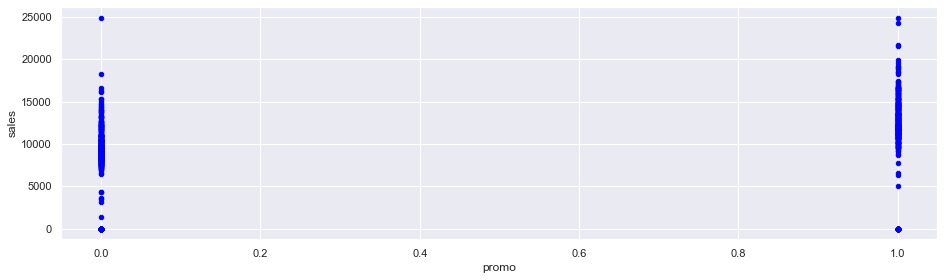

In [50]:
#Let's now draw a scatter plot between Sales and promo
df_store25[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

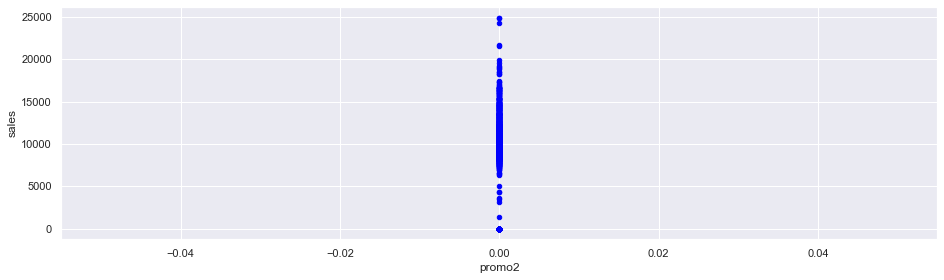

In [51]:
#Let's now draw a scatter plot between Sales and promo
df_store25[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

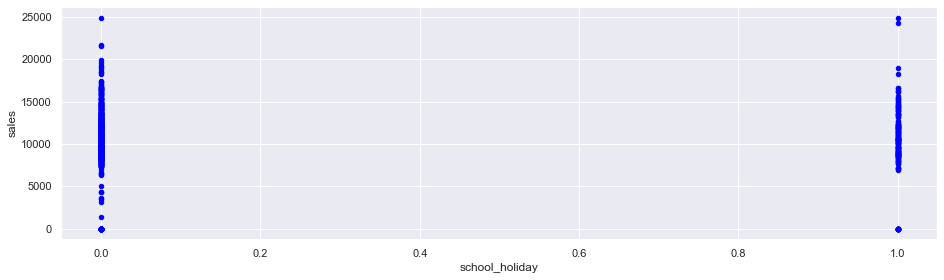

In [52]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store25[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

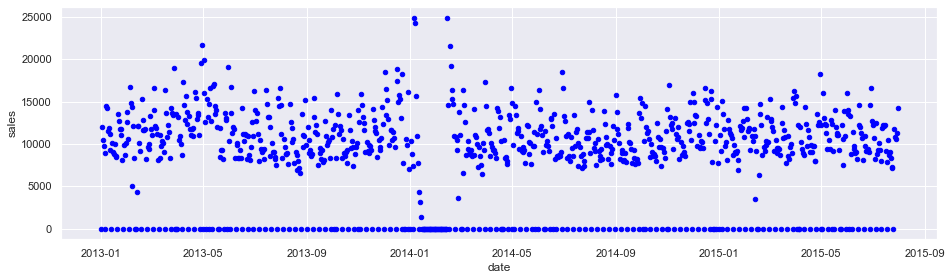

In [53]:
#lets now draw a scatter plot between Sales and date
df_store25[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

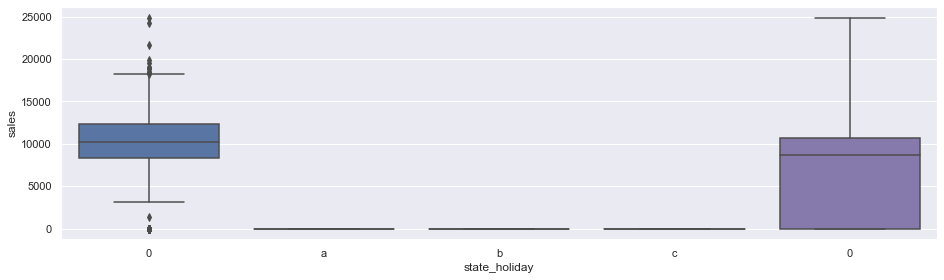

In [55]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store25['state_holiday'],
            y = df_store25['sales'])
plt.show()

**Multivariate Analysis**

**Numerical Attributes**


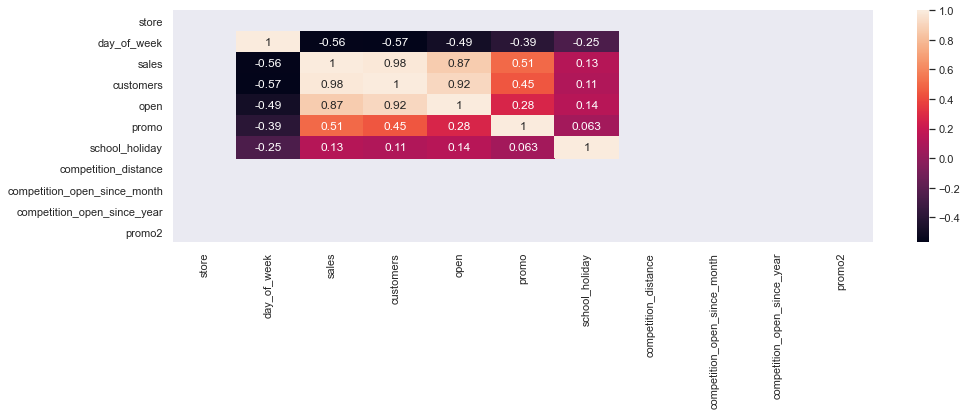

In [56]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

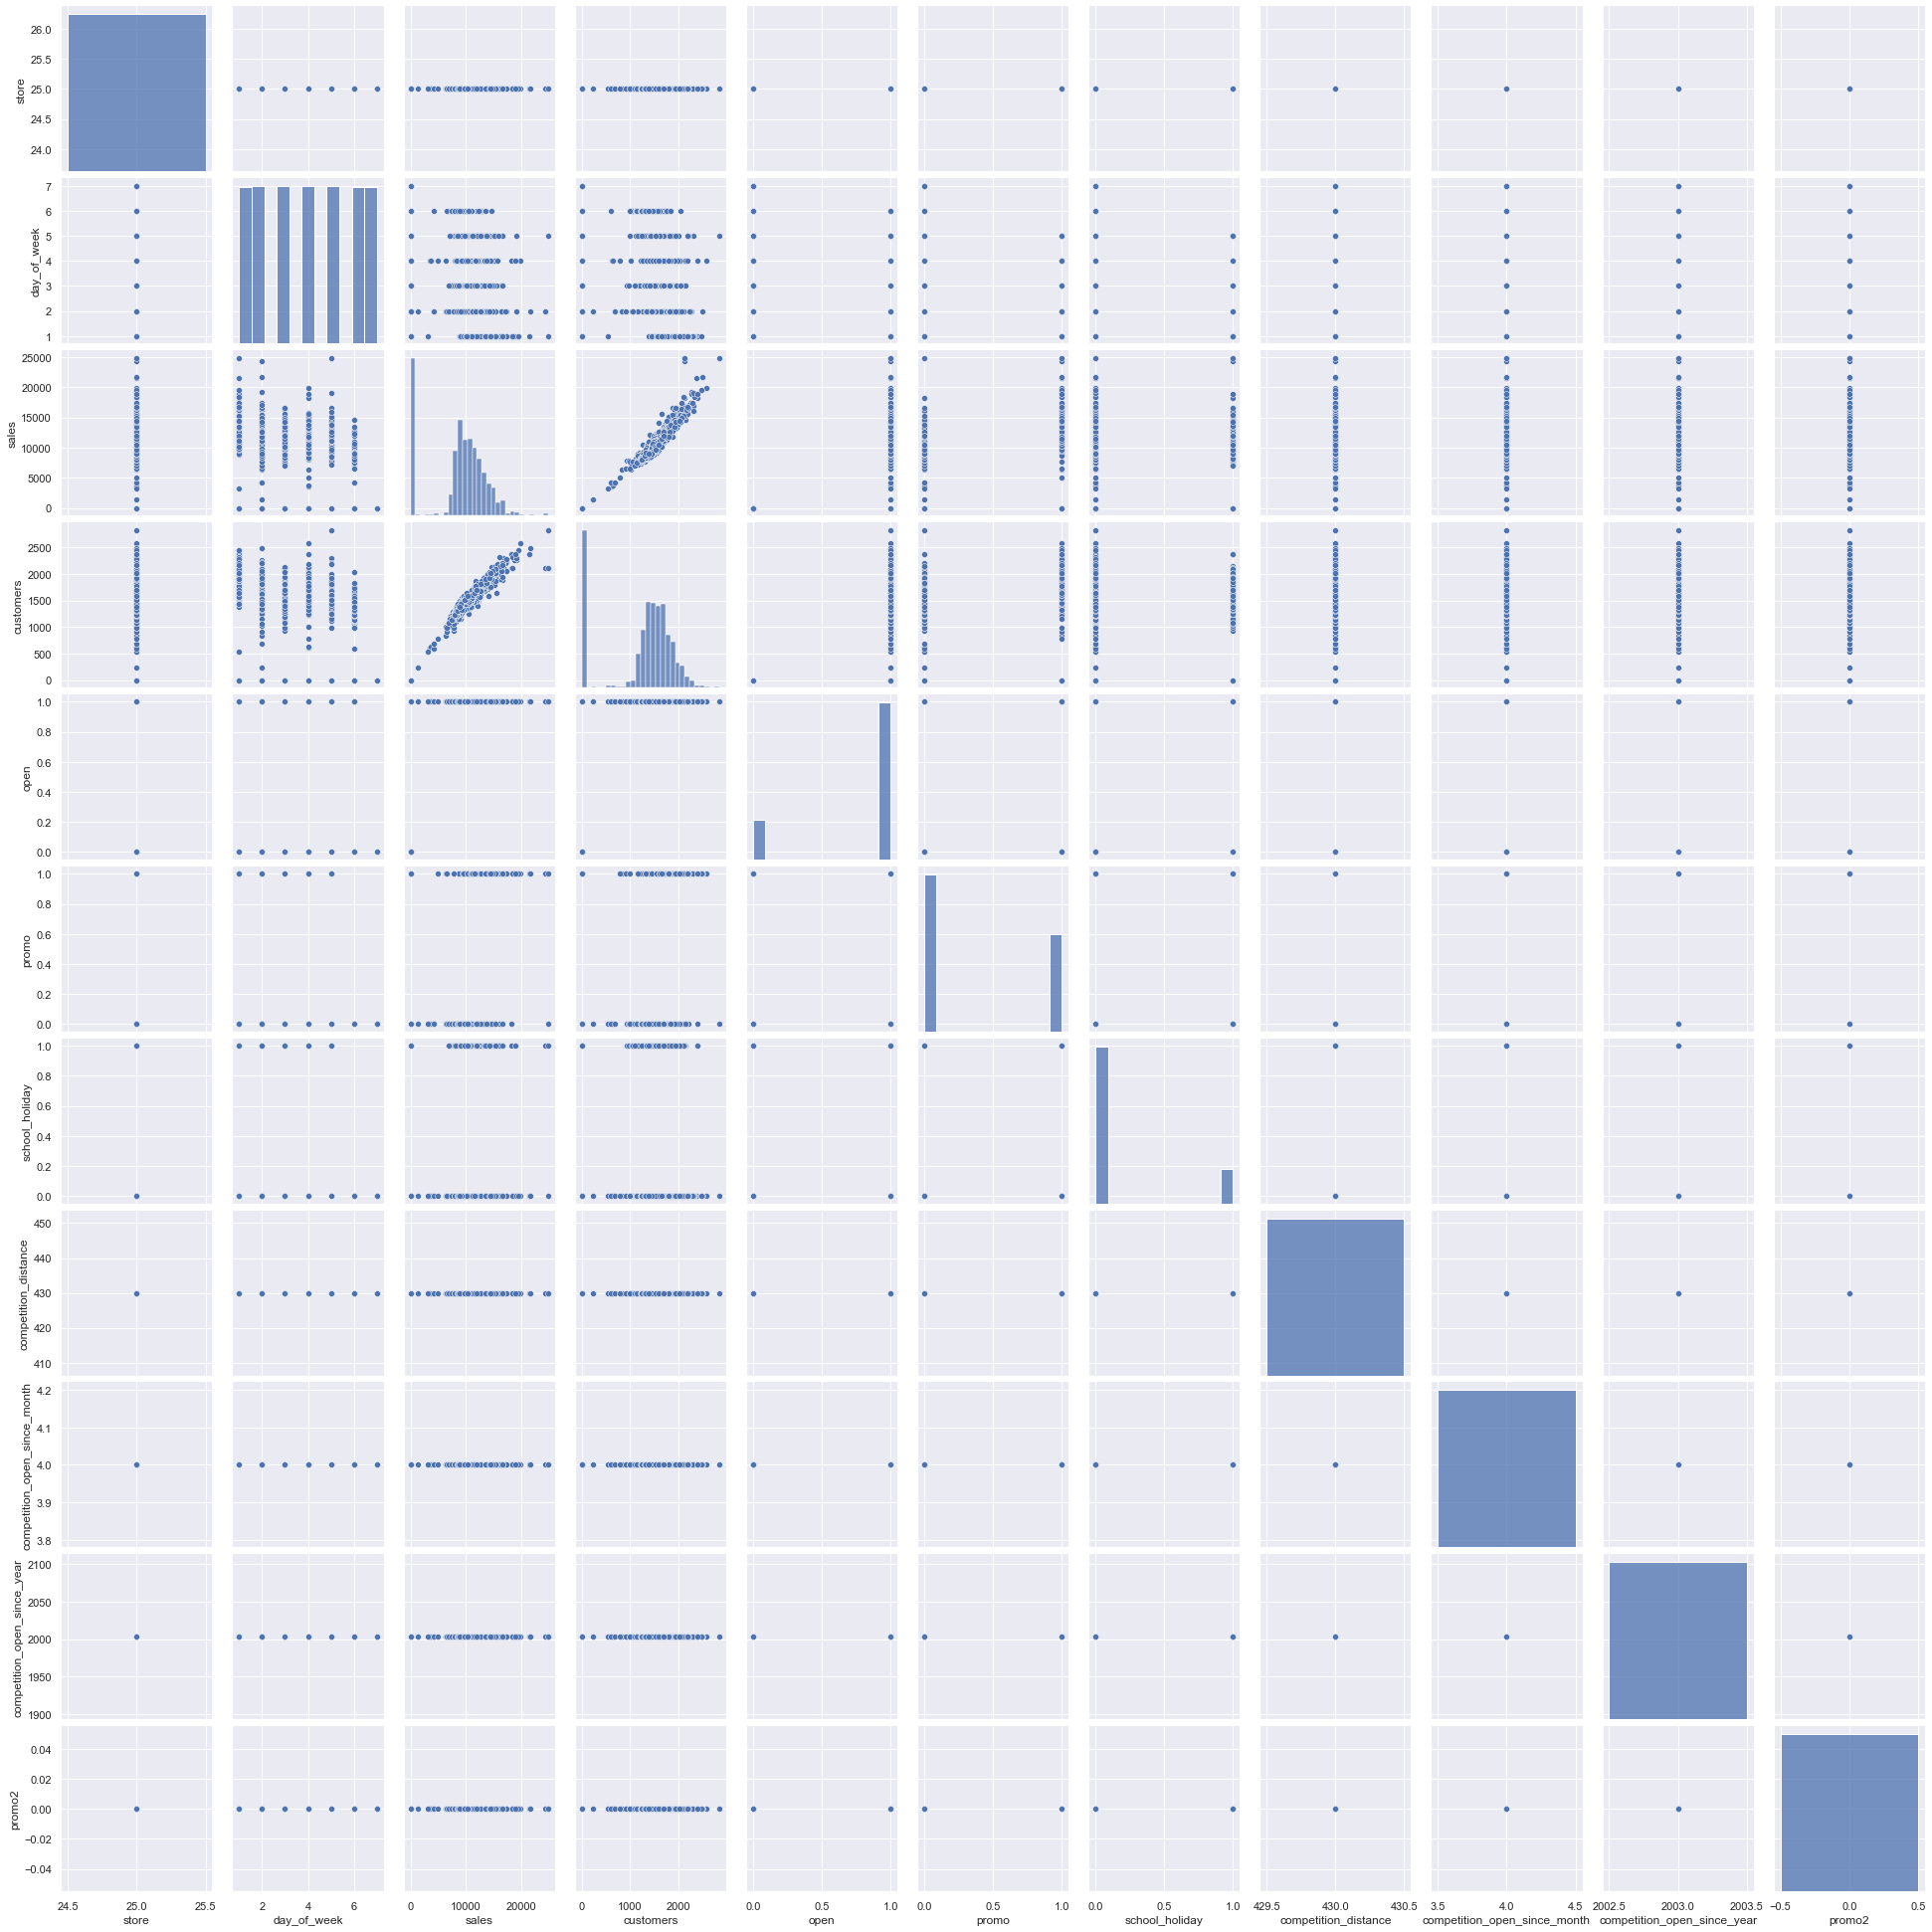

In [57]:
#pairplot with hue sales
sns.pairplot(df_store25)
# to show
plt.show()

**Some insights from EDA**

   - store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year

   - Day1,Day2 and Day5 have higher sales than other days

   - promo is correlated to sales

   - Promo2 doesn't have any effect on sales becuase it's value is equal to 0

   - There is no sale on a = public holiday, b = Easter holiday, c = Christmas

   - There is some effect of school holiday on sales

In [60]:
# We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store25_new=df_store25.drop(['store_type', 'assortment','competition_distance','competition_open_since_month','competition_open_since_year'], axis = 1)

In [61]:
df_store25_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 24 to 1016119
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [62]:
df_store25_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 24 to 1016119
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [63]:
df_store25_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
24,25,5,2015-07-31,14180,1586,1,1,0,1,0
1139,25,4,2015-07-30,11272,1422,1,1,0,1,0
2254,25,3,2015-07-29,10527,1254,1,1,0,1,0
3369,25,2,2015-07-28,10865,1363,1,1,0,1,0
4484,25,1,2015-07-27,11806,1536,1,1,0,1,0


In [64]:
# saving the dataframe
#df_store25_new.to_csv('cleaned_df_store25.csv')

# Model Building

**ARIMA model**

In [66]:
path = "cleaned_df_store25.csv"
df_store25_new = pd.read_csv(path)
df_store25_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,24,25,5,2015-07-31,14180,1586,1,1,0,1,0
1,1139,25,4,2015-07-30,11272,1422,1,1,0,1,0
2,2254,25,3,2015-07-29,10527,1254,1,1,0,1,0
3,3369,25,2,2015-07-28,10865,1363,1,1,0,1,0
4,4484,25,1,2015-07-27,11806,1536,1,1,0,1,0


In [67]:
df_store25_new=df_store25_new[::-1].reset_index()
df_store25_new.head()

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,941,1016119,25,2,2013-01-01,0,0,0,0,a,1,0
1,940,1015004,25,3,2013-01-02,11944,1698,1,0,0,1,0
2,939,1013889,25,4,2013-01-03,10409,1587,1,0,0,1,0
3,938,1012774,25,5,2013-01-04,9729,1520,1,0,0,1,0
4,937,1011659,25,6,2013-01-05,8987,1381,1,0,0,0,0


In [68]:
df_store25_new=df_store25_new.drop(['Unnamed: 0'], axis = 1)
df_store25_new=df_store25_new.drop(['index'], axis = 1)
df_store25_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,25,2,2013-01-01,0,0,0,0,a,1,0
1,25,3,2013-01-02,11944,1698,1,0,0,1,0
2,25,4,2013-01-03,10409,1587,1,0,0,1,0
3,25,5,2013-01-04,9729,1520,1,0,0,1,0
4,25,6,2013-01-05,8987,1381,1,0,0,0,0


In [69]:
df_store25_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           942 non-null    int64 
 1   day_of_week     942 non-null    int64 
 2   date            942 non-null    object
 3   sales           942 non-null    int64 
 4   customers       942 non-null    int64 
 5   open            942 non-null    int64 
 6   promo           942 non-null    int64 
 7   state_holiday   942 non-null    object
 8   school_holiday  942 non-null    int64 
 9   promo2          942 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 73.7+ KB


In [70]:
# transform datatype of the variable data to datetime
df_store25_new['date'] = pd.to_datetime(df_store25_new['date'])

In [71]:
indexed_df_store25_new = df_store25_new.set_index(['date'])
indexed_df_store25_new.head()
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,25,2,0,0,0,0,a,1,0
2013-01-02,25,3,11944,1698,1,0,0,1,0
2013-01-03,25,4,10409,1587,1,0,0,1,0
2013-01-04,25,5,9729,1520,1,0,0,1,0
2013-01-05,25,6,8987,1381,1,0,0,0,0


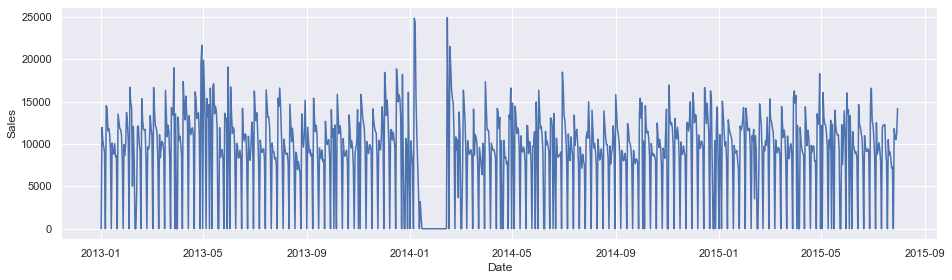

In [72]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store25_new['sales'])
plt.show()

In [74]:
#Let impute the zero values
(indexed_df_store25_new['sales']==0).sum()
# There are 192 zero value in sale column

192

In [75]:
indexed_df_store25_new['sales']=indexed_df_store25_new['sales'].replace(0, np.nan)

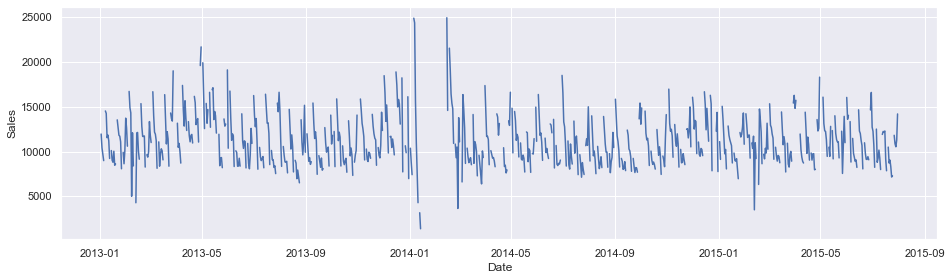

In [76]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store25_new['sales'])
plt.show()

In [77]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [78]:
indexed_df_store25_new['sales'] = imputer.fit_transform(np.array(indexed_df_store25_new['sales']).reshape(-1, 1))
indexed_df_store25_new['sales'].head()

date
2013-01-01    11168.742667
2013-01-02    11944.000000
2013-01-03    10409.000000
2013-01-04     9729.000000
2013-01-05     8987.000000
Name: sales, dtype: float64

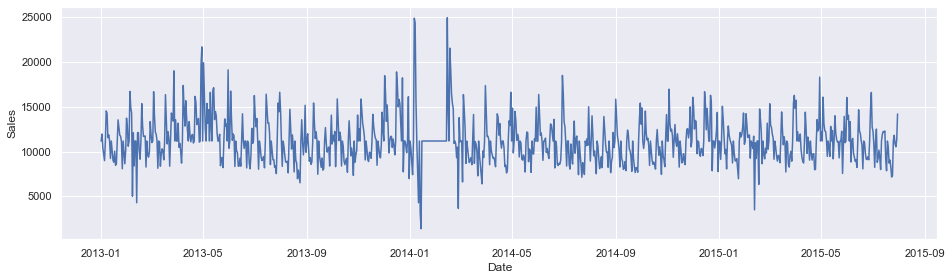

In [79]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store25_new['sales'])
plt.show()

In [81]:
(indexed_df_store25_new['sales']==25).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

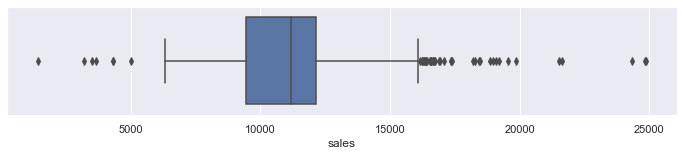

In [82]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store25_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**

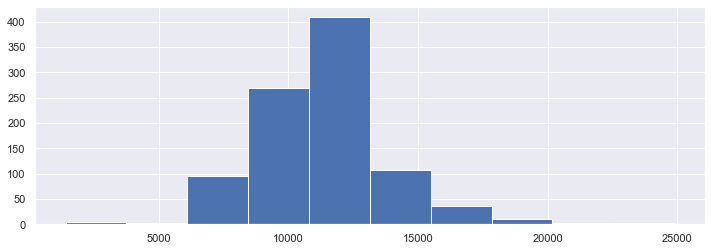

In [83]:
fig = indexed_df_store25_new['sales'].hist(figsize = (12,4))

In [84]:
percentile01 = indexed_df_store25_new['sales'].quantile(0.01)
percentile99 = indexed_df_store25_new['sales'].quantile(0.99)

In [85]:
upper_limit = percentile99
lower_limit = percentile01

In [86]:
upper_limit

18924.800000000003

In [87]:
lower_limit

6558.77

In [97]:
new_df = indexed_df_store25_new[indexed_df_store25_new['sales'] < upper_limit]
#new_df = indexed_df_store25_new[indexed_df_store25_new['sales'] > lower_limit]
new_df.shape

(932, 9)

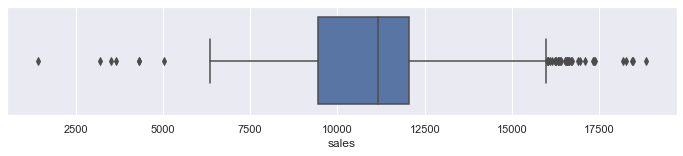

In [98]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

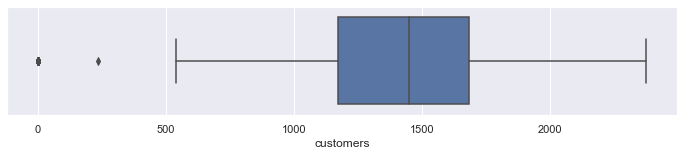

In [99]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['customers'],whis=1.5)

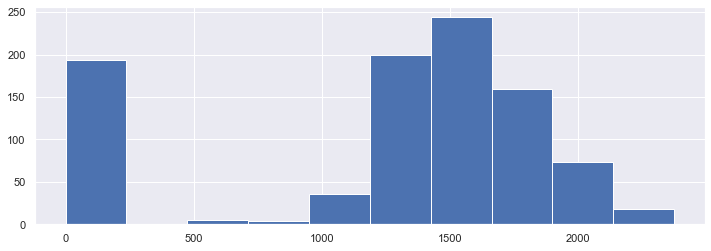

In [100]:
fig = new_df['customers'].hist(figsize = (12,4))

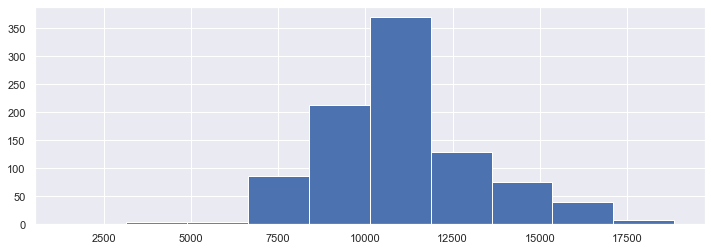

In [101]:
fig = new_df['sales'].hist(figsize = (12,4))

**ADF Stationary**


In [102]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store25_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

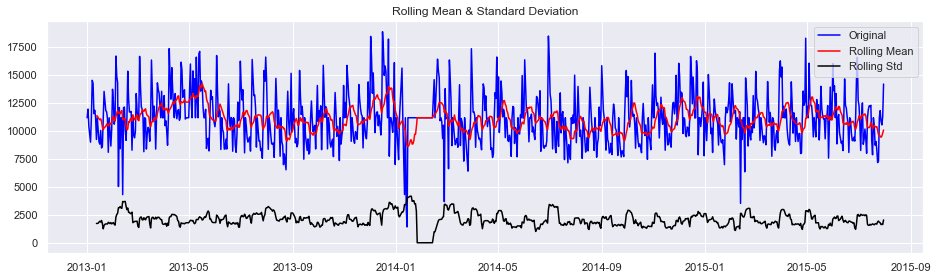

Results of Dickey Fuller Test:
Test Statistic                  -5.484273
p-value                          0.000002
#Lags Used                      22.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [103]:
test_stationarity(new_df['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [104]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.241224
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is greater than 0.05 so The series is stationary**

# Let's take the log of sales to Standardize the sales values

In [106]:
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,25,2,11168.742667,0,0,0,a,1,0
2013-01-02,25,3,11944.000000,1698,1,0,0,1,0
2013-01-03,25,4,10409.000000,1587,1,0,0,1,0
2013-01-04,25,5,9729.000000,1520,1,0,0,1,0
2013-01-05,25,6,8987.000000,1381,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2015-07-27,25,1,11806.000000,1536,1,1,0,1,0
2015-07-28,25,2,10865.000000,1363,1,1,0,1,0
2015-07-29,25,3,10527.000000,1254,1,1,0,1,0


In [107]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,25,2,11168.742667,0,0,0,a,1,0,9.320874
2013-01-02,25,3,11944.000000,1698,1,0,0,1,0,9.387984
2013-01-03,25,4,10409.000000,1587,1,0,0,1,0,9.250426
2013-01-04,25,5,9729.000000,1520,1,0,0,1,0,9.182866
2013-01-05,25,6,8987.000000,1381,1,0,0,0,0,9.103534
...,...,...,...,...,...,...,...,...,...,...
2015-07-27,25,1,11806.000000,1536,1,1,0,1,0,9.376363
2015-07-28,25,2,10865.000000,1363,1,1,0,1,0,9.293302
2015-07-29,25,3,10527.000000,1254,1,1,0,1,0,9.261699


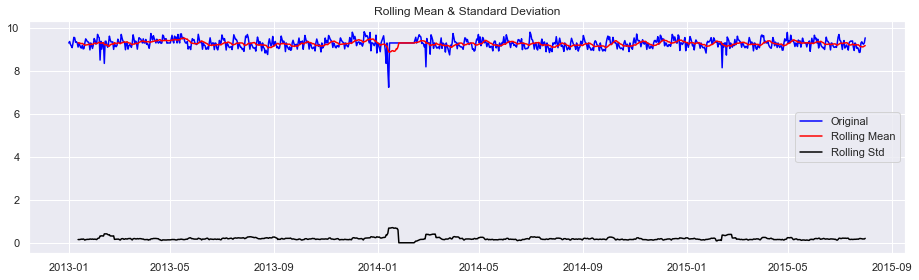

Results of Dickey Fuller Test:
Test Statistic                  -5.484273
p-value                          0.000002
#Lags Used                      22.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [108]:
test_stationarity(new_df['sales_log'])

**Log transformation has made mean & variance constant**

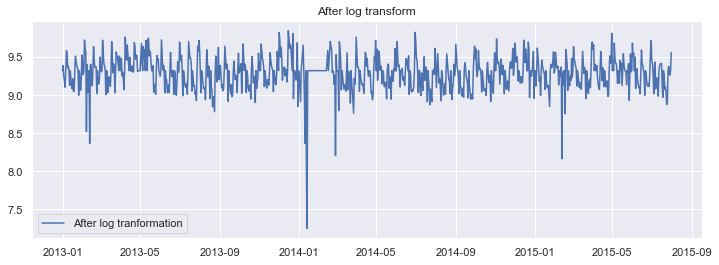

In [109]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After log transform')
plt.show()

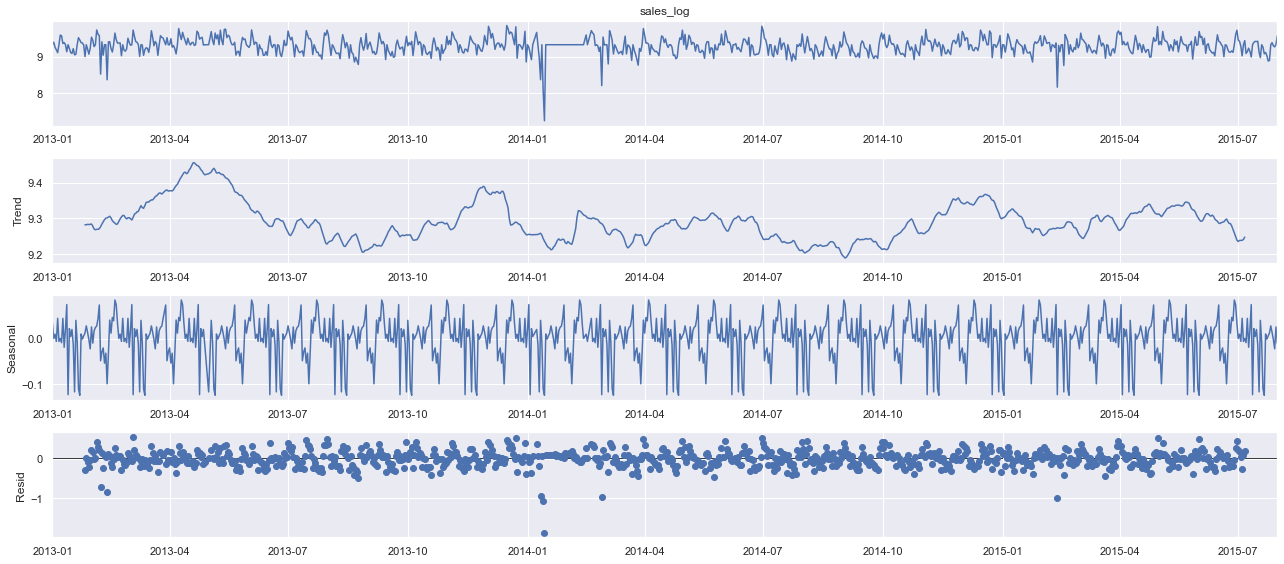

In [110]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

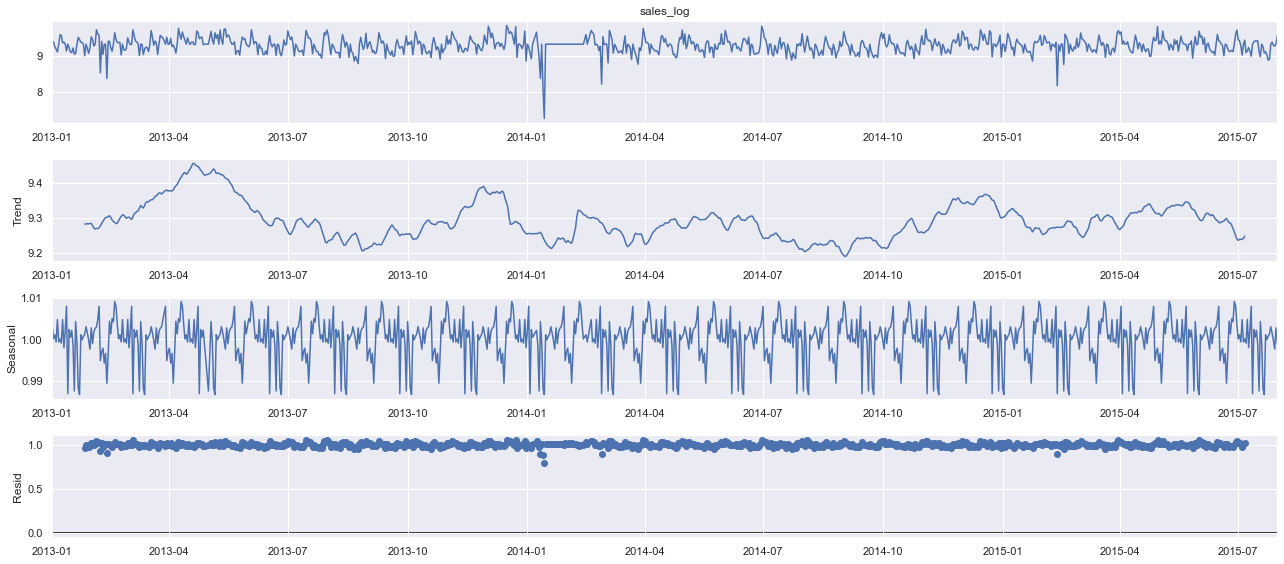

In [111]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

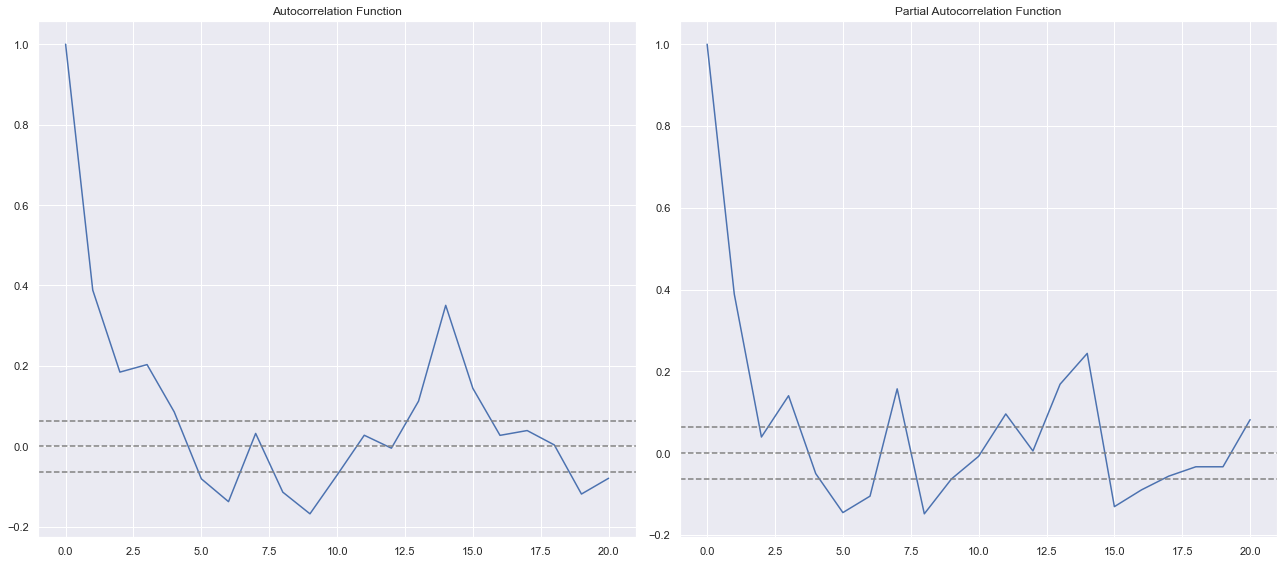

In [112]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=4. Thus, from theory, Q = 4 From the PACF graph, we see that curve touches y=0.0 line at x=4. Thus, from theory, P = 4

**Build and evaluate time series forecast**

Split time series data into training and test set

In [114]:
train_len = 750
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [115]:
print(train.shape)
print(test.shape)

(750,)
(182,)


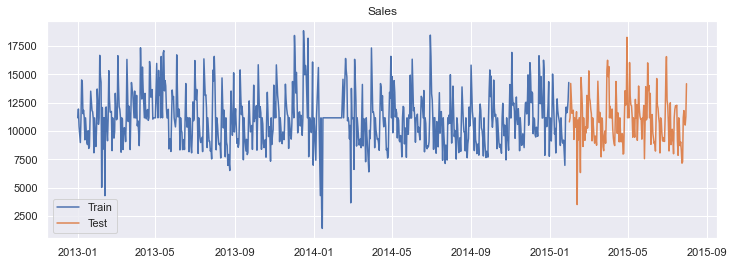

In [116]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [117]:
model = ARIMA(new_df['sales_log'], order=(2, 0, 2))
model_fit = model.fit()
print(model_fit.params)

const              9.288991
ar.L1.sales_log   -0.084259
ar.L2.sales_log    0.453973
ma.L1.sales_log    0.475716
ma.L2.sales_log   -0.293655
dtype: float64


In [118]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    10818.258769
2013-01-02    10954.870688
2013-01-03    11245.970725
2013-01-04    10682.145202
2013-01-05    10497.741179
                  ...     
2015-07-27    10629.947277
2015-07-28    10778.683855
2015-07-29    10951.946526
2015-07-30    10636.845732
2015-07-31    11073.946302
Name: arima_forecast, Length: 932, dtype: float64

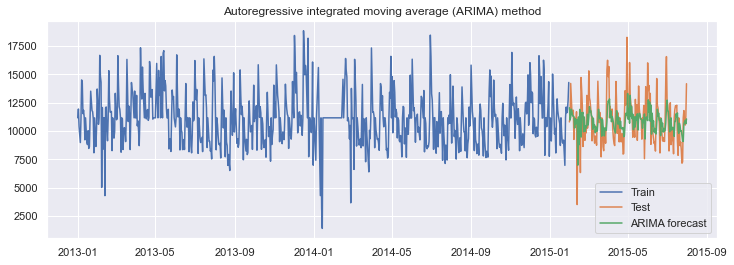

In [119]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

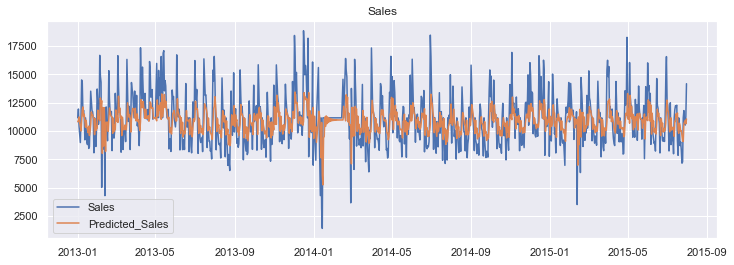

In [121]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

**Model Evalution**

In [122]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results

,Method,RMSE,MAPE
0,ARIMA,1950.91,14.2


**VAR model**

In [123]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,25,2,11168.742667,0,0,0,a,1,0,9.320874,9.288991,10818.258769
2013-01-02,25,3,11944.000000,1698,1,0,0,1,0,9.387984,9.301539,10954.870688
2013-01-03,25,4,10409.000000,1587,1,0,0,1,0,9.250426,9.327765,11245.970725
2013-01-04,25,5,9729.000000,1520,1,0,0,1,0,9.182866,9.276329,10682.145202
2013-01-05,25,6,8987.000000,1381,1,0,0,0,0,9.103534,9.258915,10497.741179


**Split the dataset to training & testing**

In [124]:
#split the dataset
nobs = 182
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(750, 12)
(182, 12)


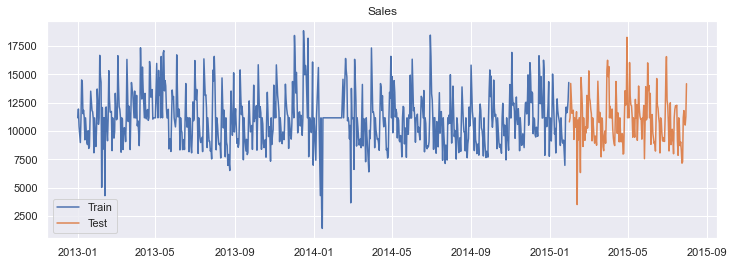

In [125]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

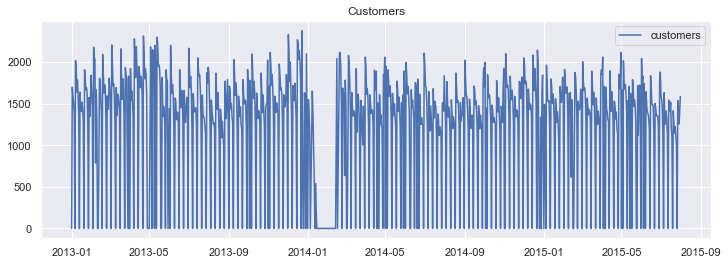

In [126]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [127]:
(new_df['customers']==0).sum()

192

In [128]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

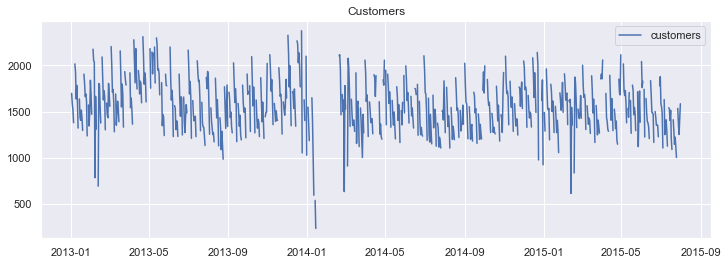

In [129]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [130]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [131]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers'].head()

date
2013-01-01    1559.32027
2013-01-02    1698.00000
2013-01-03    1587.00000
2013-01-04    1520.00000
2013-01-05    1381.00000
Name: customers, dtype: float64

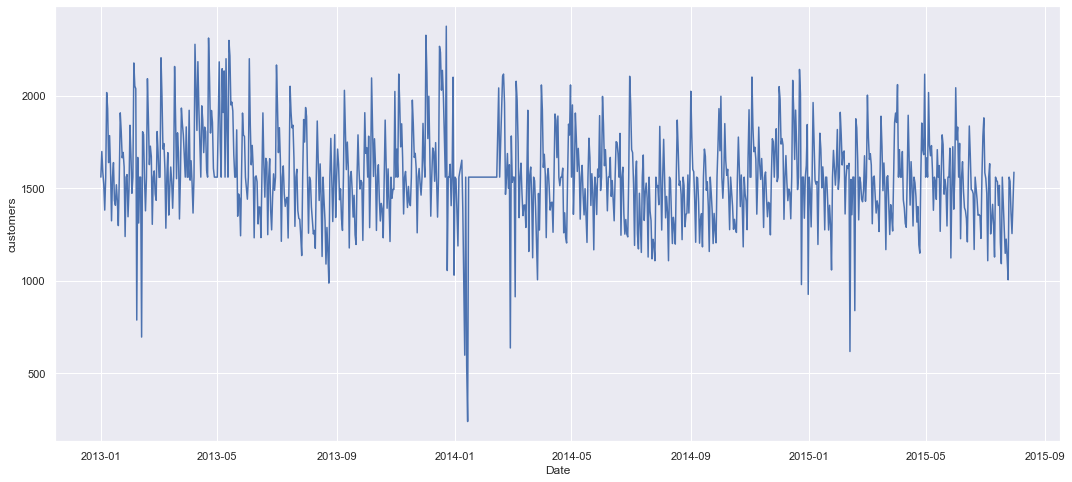

In [132]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [133]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,25,2,11168.742667,1559.32027,0,0,a,1,0,9.320874,9.288991,10818.258769
2013-01-02,25,3,11944.000000,1698.00000,1,0,0,1,0,9.387984,9.301539,10954.870688
2013-01-03,25,4,10409.000000,1587.00000,1,0,0,1,0,9.250426,9.327765,11245.970725
2013-01-04,25,5,9729.000000,1520.00000,1,0,0,1,0,9.182866,9.276329,10682.145202
2013-01-05,25,6,8987.000000,1381.00000,1,0,0,0,0,9.103534,9.258915,10497.741179


**ADF test**


In [134]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

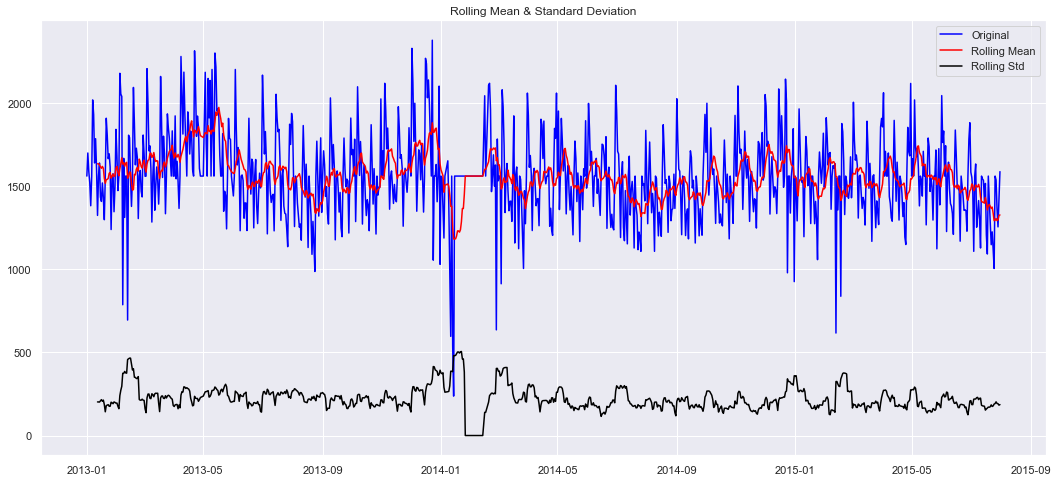

Results of Dickey Fuller Test:
Test Statistic                  -4.624408
p-value                          0.000116
#Lags Used                      21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


In [135]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [136]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.810743
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is greater than 0.05 so The series is stationary**

**Let's use Log transformation to make mean & variance constant**

In [138]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,25,2,11168.742667,1559.32027,0,0,a,1,0,9.320874,9.288991,10818.258769,7.352005
2013-01-02,25,3,11944.000000,1698.00000,1,0,0,1,0,9.387984,9.301539,10954.870688,7.437206
2013-01-03,25,4,10409.000000,1587.00000,1,0,0,1,0,9.250426,9.327765,11245.970725,7.369601
2013-01-04,25,5,9729.000000,1520.00000,1,0,0,1,0,9.182866,9.276329,10682.145202,7.326466
2013-01-05,25,6,8987.000000,1381.00000,1,0,0,0,0,9.103534,9.258915,10497.741179,7.230563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,25,1,11806.000000,1536.00000,1,1,0,1,0,9.376363,9.271431,10629.947277,7.336937
2015-07-28,25,2,10865.000000,1363.00000,1,1,0,1,0,9.293302,9.285326,10778.683855,7.217443
2015-07-29,25,3,10527.000000,1254.00000,1,1,0,1,0,9.261699,9.301272,10951.946526,7.134094


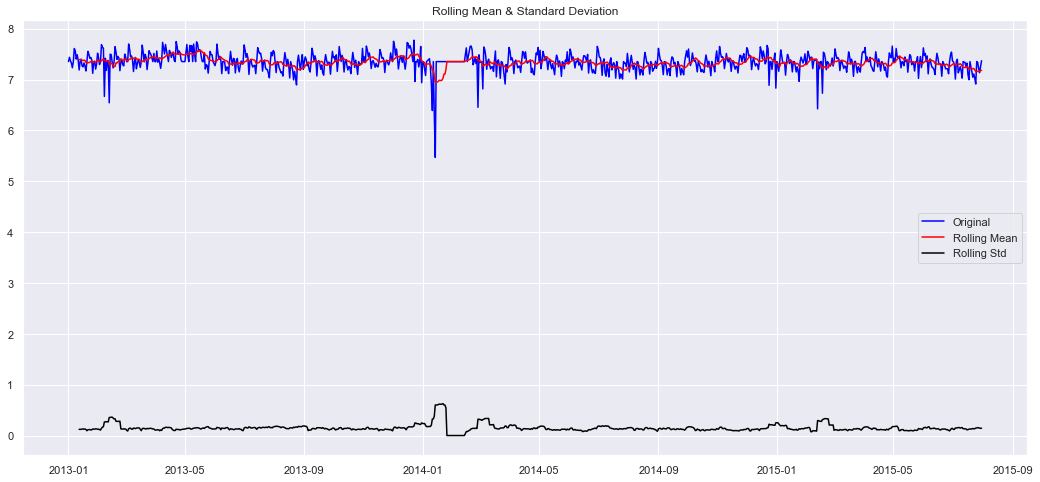

Results of Dickey Fuller Test:
Test Statistic                  -4.624408
p-value                          0.000116
#Lags Used                      21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


In [139]:
test_stationarity(new_df['customers_log'])

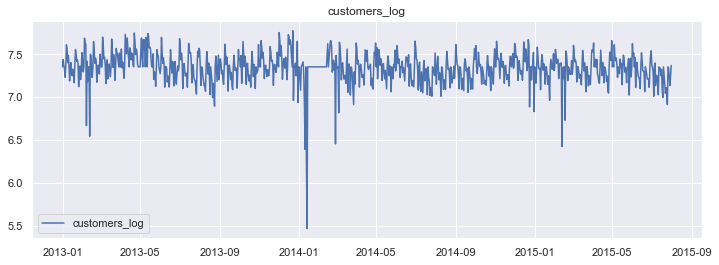

In [140]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [141]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2013-01-01 to 2015-07-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            932 non-null    int64  
 1   day_of_week      932 non-null    int64  
 2   sales            932 non-null    float64
 3   customers        932 non-null    float64
 4   open             932 non-null    int64  
 5   promo            932 non-null    int64  
 6   state_holiday    932 non-null    object 
 7   school_holiday   932 non-null    int64  
 8   promo2           932 non-null    int64  
 9   sales_log        932 non-null    float64
 10  ar_forecast_Log  932 non-null    float64
 11  arima_forecast   932 non-null    float64
 12  customers_log    932 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 141.9+ KB


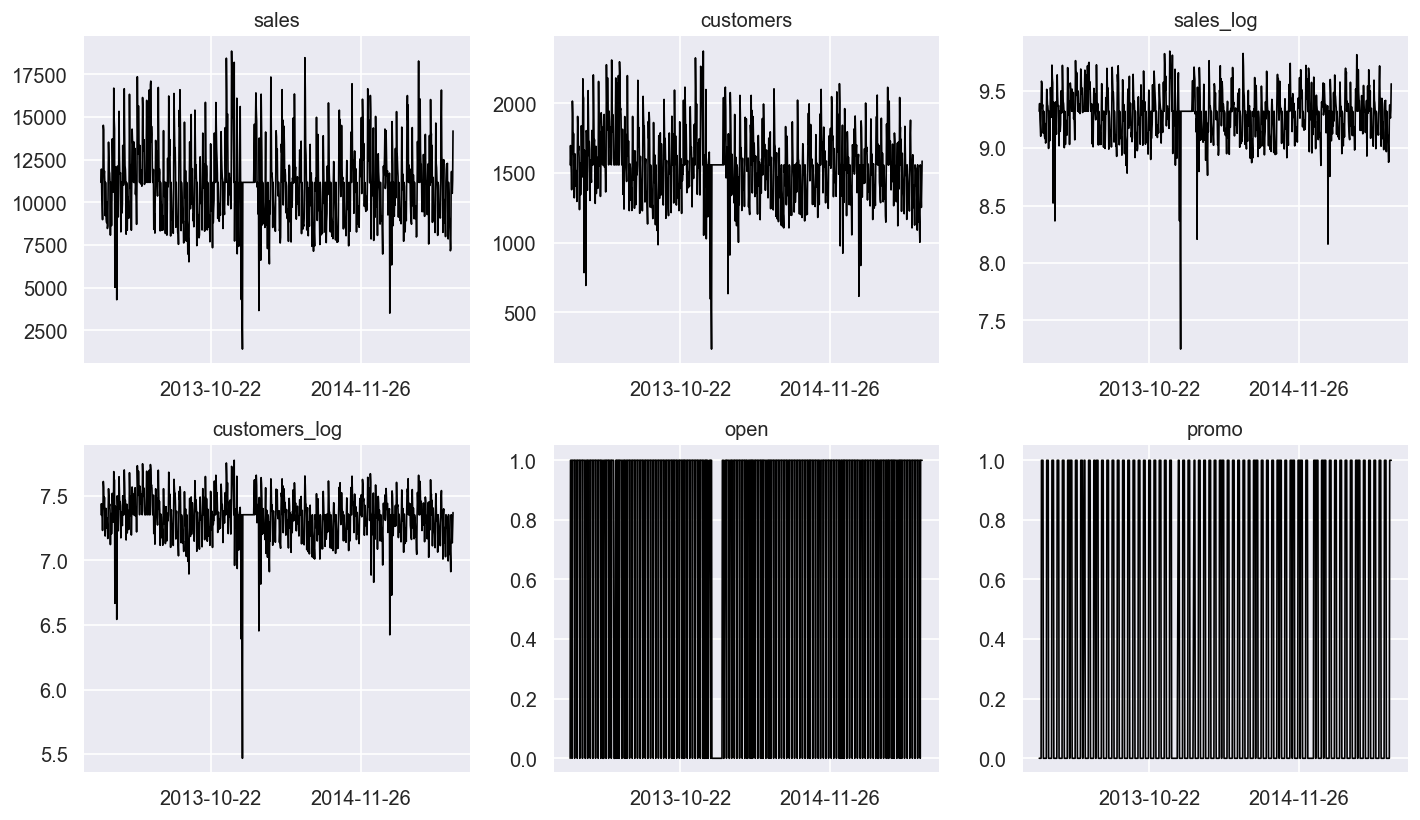

In [142]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [143]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [144]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,9.320874,7.352005
2013-01-02,9.387984,7.437206
2013-01-03,9.250426,7.369601
2013-01-04,9.182866,7.326466
2013-01-05,9.103534,7.230563
...,...,...
2015-07-27,9.376363,7.336937
2015-07-28,9.293302,7.217443
2015-07-29,9.261699,7.134094


In [145]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.512717230515774
BIC :  -9.481549071908187
FPE :  7.390595244920688e-05
HQIC:  -9.500830132435228 

Lag Order = 2
AIC :  -9.53071830414248
BIC :  -9.478727072033369
FPE :  7.258748042548126e-05
HQIC:  -9.510888551974064 

Lag Order = 3
AIC :  -9.614356947342923
BIC :  -9.541507084755846
FPE :  6.676334357508933e-05
HQIC:  -9.586570155286607 

Lag Order = 4
AIC :  -9.629585856106221
BIC :  -9.535841706116834
FPE :  6.575435589224836e-05
HQIC:  -9.593827596888415 

Lag Order = 5
AIC :  -9.64598823995727
BIC :  -9.531314045305221
FPE :  6.46846902005054e-05
HQIC:  -9.602244044667545 



In [146]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-9.049,-9.038,0.0001175,-9.045
1,-9.508,-9.476,7.428e-05,-9.496
2,-9.528,-9.476,7.280e-05,-9.508
3,-9.612,-9.539*,6.695e-05,-9.584
4,-9.628,-9.534,6.589e-05,-9.592
5,-9.646*,-9.531,6.468e-05*,-9.602*


In [147]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Jan, 2022
Time:                     14:57:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.48155
Nobs:                     931.000    HQIC:                  -9.50083
Log likelihood:           1792.11    FPE:                7.39060e-05
AIC:                     -9.51272    Det(Omega_mle):     7.34319e-05
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    5.724988         0.274523           20.854           0.000
L1.sales_log             1.095451         0.107645           10.176           0.000
L1.customers_log        -0.901033         0.

In [148]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [149]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[9.5595878, 7.3689704]])

In [150]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=182)
df_forecast = pd.DataFrame(fc, index=new_df.index[-182:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2015-01-31,9.557358,7.461708
2015-02-01,9.471355,7.438128
2015-02-02,9.398390,7.402033
2015-02-03,9.350982,7.375314
2015-02-04,9.323125,7.358746
...,...,...
2015-07-27,9.289361,7.337869
2015-07-28,9.289361,7.337869
2015-07-29,9.289361,7.337869


In [151]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2015-01-31,9.557358,7.461708,14148.411948,1740.118078
2015-02-01,9.471355,7.438128,12982.463961,1699.565095
2015-02-02,9.398390,7.402033,12068.931627,1639.314342
2015-02-03,9.350982,7.375314,11510.125666,1596.092280
2015-02-04,9.323125,7.358746,11193.912308,1569.866482
...,...,...,...,...
2015-07-27,9.289361,7.337869,10822.268632,1537.432329
2015-07-28,9.289361,7.337869,10822.268632,1537.432329
2015-07-29,9.289361,7.337869,10822.268632,1537.432329


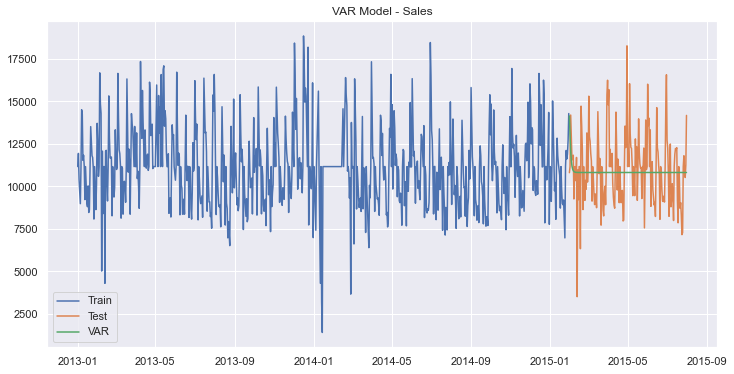

In [152]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [153]:
train_len = 750
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [154]:
train1

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,25,2,11168.742667,1559.32027,0,0,a,1,0,9.320874,9.288991,10818.258769,7.352005
2013-01-02,25,3,11944.000000,1698.00000,1,0,0,1,0,9.387984,9.301539,10954.870688,7.437206
2013-01-03,25,4,10409.000000,1587.00000,1,0,0,1,0,9.250426,9.327765,11245.970725,7.369601
2013-01-04,25,5,9729.000000,1520.00000,1,0,0,1,0,9.182866,9.276329,10682.145202,7.326466
2013-01-05,25,6,8987.000000,1381.00000,1,0,0,0,0,9.103534,9.258915,10497.741179,7.230563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-26,25,1,12118.000000,1704.00000,1,1,0,0,0,9.402447,9.273292,10649.757003,7.440734
2015-01-27,25,2,11614.000000,1611.00000,1,1,0,0,0,9.359967,9.295097,10884.518925,7.384610
2015-01-28,25,3,11906.000000,1516.00000,1,1,0,0,0,9.384798,9.327449,11242.416355,7.323831


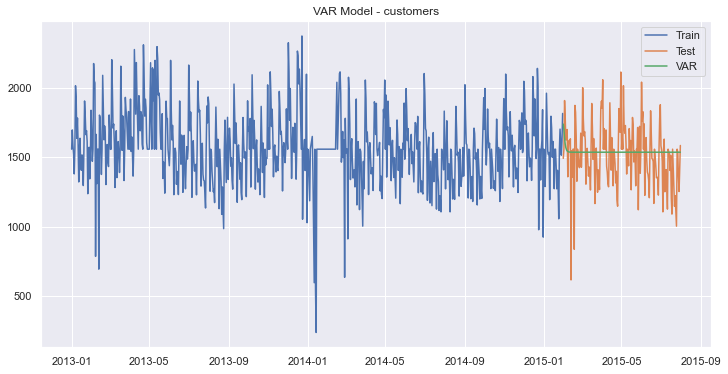

In [155]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

**Model Evalution**

In [156]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-df_forecast['VAR_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [157]:
tempResults

,Method,RMSE,MAPE
0,VAR,2093.97,15.23


In [158]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1950.91,14.20
0,VAR,2093.97,15.23


**Johansen-Impulse**

In [159]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [160]:
joh_model1

In [161]:
joh_model1.lr1

array([160.8017268 ,   3.18075708])

In [162]:
joh_model1.lr2

array([157.62096972,   3.18075708])

In [163]:
new_df[['sales','customers']].shape

(932, 2)

In [164]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [165]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    157.620970  160.801727
1      3.180757    3.180757 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [166]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [167]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

1


**Rank is one**

In [169]:
from statsmodels.tsa.stattools import coint

In [170]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-3.3670212871767604,
 0.04614770256599787,
 array([-3.90824227, -3.34270081, -3.04900867]))

0.04614770256599787<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**


In [172]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,25,2,11168.742667,1559.32027,0,0,1,0,9.320874,9.288991,10818.258769,7.352005,0,1,0,0
2013-01-02,25,3,11944.000000,1698.00000,1,0,1,0,9.387984,9.301539,10954.870688,7.437206,1,0,0,0
2013-01-03,25,4,10409.000000,1587.00000,1,0,1,0,9.250426,9.327765,11245.970725,7.369601,1,0,0,0
2013-01-04,25,5,9729.000000,1520.00000,1,0,1,0,9.182866,9.276329,10682.145202,7.326466,1,0,0,0
2013-01-05,25,6,8987.000000,1381.00000,1,0,0,0,9.103534,9.258915,10497.741179,7.230563,1,0,0,0


In [173]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,25,2,11168.742667,1559.32027,0,0,1,0,9.320874,9.288991,10818.258769,7.352005,0,1,0,0
2013-01-02,25,3,11944.000000,1698.00000,1,0,1,0,9.387984,9.301539,10954.870688,7.437206,1,0,0,0
2013-01-03,25,4,10409.000000,1587.00000,1,0,1,0,9.250426,9.327765,11245.970725,7.369601,1,0,0,0
2013-01-04,25,5,9729.000000,1520.00000,1,0,1,0,9.182866,9.276329,10682.145202,7.326466,1,0,0,0
2013-01-05,25,6,8987.000000,1381.00000,1,0,0,0,9.103534,9.258915,10497.741179,7.230563,1,0,0,0


In [174]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  932
Model:                                VARMAX(1,1)   Log Likelihood                1925.958
Date:                            Sat, 15 Jan 2022   AIC                          -3797.916
Time:                                    15:05:29   BIC                          -3667.308
Sample:                                         0   HQIC                         -3748.107
                                            - 932                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             0.03, 0.17   Jarque-Bera (JB):      6884.07, 289.68
Prob(Q):                        0.86, 0.68   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.89, 1.38   Skew:                     -1.53, -0.61
Prob(H) (two-sided):

In [175]:
train_len = 750
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [176]:
print(start_index)
print(end_index)

2015-01-31 00:00:00
2015-07-31 00:00:00


In [177]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2015-01-31,25,6,10810.000000,1493.00000,1,0,0,0,9.288227,9.397882,12062.803482,7.308543,1,0,0,0
2015-02-01,25,7,11168.742667,1559.32027,0,0,0,0,9.320874,9.303400,10975.274492,7.352005,1,0,0,0
2015-02-02,25,1,14202.000000,1910.00000,1,1,0,0,9.561138,9.326471,11231.424091,7.554859,1,0,0,0
2015-02-03,25,2,12976.000000,1788.00000,1,1,0,0,9.470857,9.387038,11932.698771,7.488853,1,0,0,0
2015-02-04,25,3,11565.000000,1625.00000,1,1,0,0,9.355739,9.368177,11709.750249,7.393263,1,0,0,0


In [178]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [179]:
predictions

,sales_log,customers_log
date,,
2015-01-31,9.320756,7.356446
2015-02-01,9.356488,7.376098
2015-02-02,9.387830,7.407829
2015-02-03,9.457724,7.467930
2015-02-04,9.427839,7.446504
...,...,...
2015-07-27,9.371438,7.374670
2015-07-28,9.418937,7.392217
2015-07-29,9.421264,7.374725


In [180]:
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
date,,,,
2015-01-31,9.320756,7.356446,11167.417488,1566.260480
2015-02-01,9.356488,7.376098,11573.670588,1597.344951
2015-02-02,9.387830,7.407829,11942.157547,1648.842382
2015-02-03,9.457724,7.467930,12806.697578,1750.978819
2015-02-04,9.427839,7.446504,12429.638959,1713.860765
...,...,...,...,...
2015-07-27,9.371438,7.374670,11747.991697,1595.066111
2015-07-28,9.418937,7.392217,12319.483891,1623.301574
2015-07-29,9.421264,7.374725,12348.178756,1595.153558


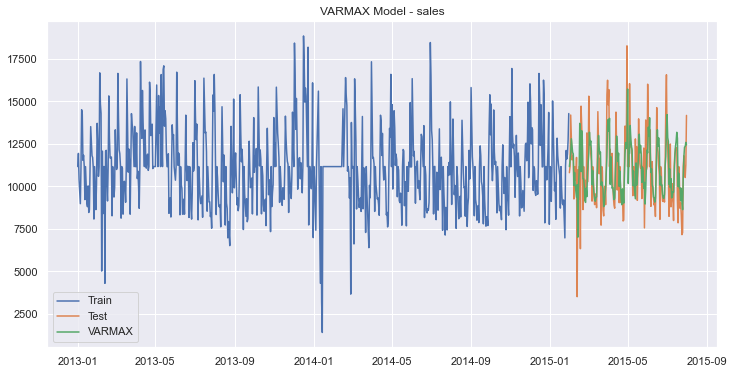

In [181]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

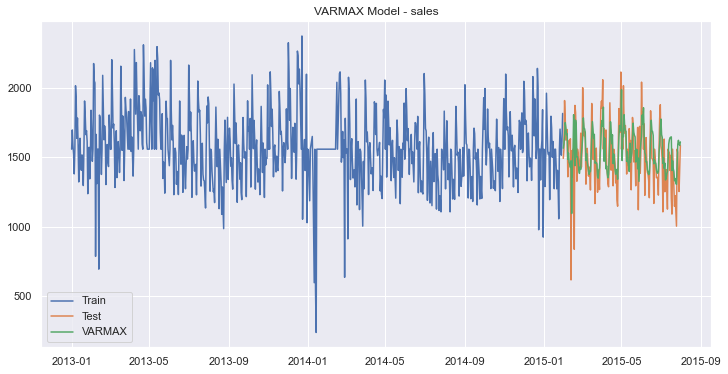

In [182]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

**Model evalution**

In [183]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [184]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1950.91,14.20
0,VAR,2093.97,15.23
0,VARMAX,1701.90,11.48


**VARMAX is the best model**

-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion

-   The data is stationary
-   Sales and Customers are cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales